In [150]:
import torch
import torch.nn as nn
import pandas as pd
import spacy
from textblob import TextBlob
import numpy as np
import nltk
import nltk.data
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentPoolEmbeddings, Sentence, BertEmbeddings
from spacy.gold import biluo_tags_from_offsets
import matplotlib.pyplot as plt
%matplotlib inline

In [151]:
# nltk.download('punkt')
# nlp = spacy.load("en_core_web_sm")
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# flair_embedding= BertEmbeddings(bert_model_or_path="bert-large-uncased-whole-word-masking-finetuned-squad")
embeddings = WordEmbeddings('glove')
EMBEDDING_DIM = 100
# initialize the document embeddings, mode = mean
document_embeddings = DocumentPoolEmbeddings([embeddings],pooling='max')

In [152]:
train_df =  pd.read_csv("D:\\SQUAD2\\train.csv",header=None,names=["question","paragraph","answer_span","start","end"])
dev_df =  pd.read_csv("D:\\SQUAD2\\dev.csv",header=None,names=["question","paragraph","answer_span","start","end"])

In [153]:
train_df.head()

question  \
0           When did Beyonce start becoming popular?   
1  What areas did Beyonce compete in when she was...   
2  When did Beyonce leave Destiny's Child and bec...   
3      In what city and state did Beyonce  grow up?    
4         In which decade did Beyonce become famous?   

                                           paragraph          answer_span  \
0  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...    in the late 1990s   
1  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...  singing and dancing   
2  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...                 2003   
3  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...       Houston, Texas   
4  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...           late 1990s   

   start  end  
0    269  286  
1    207  226  
2    526  530  
3    166  180  
4    276  286

In [154]:
train_df.dtypes

question       object
paragraph      object
answer_span    object
start           int64
end             int64
dtype: object

In [155]:
train_df["q_len"]=train_df["question"].map(lambda question: len(question.split()))
train_df["p_len"]=train_df["paragraph"].map(lambda paragraph: len(paragraph.split()))
train_df["answer_span_len"]=train_df["answer_span"].map(lambda answer_span: len(str(answer_span).split()))

In [156]:
train_df.head()

question  \
0           When did Beyonce start becoming popular?   
1  What areas did Beyonce compete in when she was...   
2  When did Beyonce leave Destiny's Child and bec...   
3      In what city and state did Beyonce  grow up?    
4         In which decade did Beyonce become famous?   

                                           paragraph          answer_span  \
0  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...    in the late 1990s   
1  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...  singing and dancing   
2  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...                 2003   
3  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...       Houston, Texas   
4  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...           late 1990s   

   start  end  q_len  p_len  answer_span_len  
0    269  286      6    109                4  
1    207  226     11    109                3  
2    526  530     11    109                1  
3    166  180      9    109                2  
4    276  286      7    109                2

In [157]:
train_df.describe()

start           end         q_len         p_len  answer_span_len
count  86821.000000  86821.000000  86821.000000  86821.000000     86821.000000
mean     319.806475    339.955644     10.066378    119.794347         3.162772
std      266.390192    267.705780      3.555650     49.409714         3.390947
min        0.000000      1.000000      1.000000     20.000000         1.000000
25%      111.000000    131.000000      8.000000     89.000000         1.000000
50%      262.000000    282.000000     10.000000    110.000000         2.000000
75%      468.000000    491.000000     12.000000    142.000000         4.000000
max     3126.000000   3136.000000     40.000000    653.000000        43.000000

In [158]:
train_df['p_len'].plot.hist()
plt.show()

In [159]:
train_df['q_len'].plot.hist()
plt.show()

In [160]:
train_df['answer_span_len'].plot.hist()
plt.show()

In [161]:
def sentence_tokenizer(paragraph,tokenizer="textblob"):
    if tokenizer=="spacy":
        doc = nlp(paragraph)
        sentences = [sent.text for sent in doc.sents]
        return sentences,len(sentences)
    elif tokenizer=="nltk":    
        sentences = TextBlob(paragraph)
        return sentences,len(sentences)
    else:
        sentences = nltk.tokenize.sent_tokenize(paragraph)
        return sentences,len(sentences)


In [162]:
# train_df["spacy"]=train_df["paragraph"].map(lambda paragraph: sentence_tokenizer(paragraph,"spacy") )
# train_df["nltk"]=train_df["paragraph"].map(lambda paragraph: sentence_tokenizer(paragraph),"nltk")
train_df["sentences"]=train_df["paragraph"].map(lambda paragraph: sentence_tokenizer(paragraph)[0])   
train_df["sentences_len"]=train_df["paragraph"].map(lambda paragraph: sentence_tokenizer(paragraph)[1]) #waste cpu 

In [163]:
train_df.head()

question  \
0           When did Beyonce start becoming popular?   
1  What areas did Beyonce compete in when she was...   
2  When did Beyonce leave Destiny's Child and bec...   
3      In what city and state did Beyonce  grow up?    
4         In which decade did Beyonce become famous?   

                                           paragraph          answer_span  \
0  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...    in the late 1990s   
1  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...  singing and dancing   
2  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...                 2003   
3  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...       Houston, Texas   
4  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...           late 1990s   

   start  end  q_len  p_len  answer_span_len  \
0    269  286      6    109                4   
1    207  226     11    109                3   
2    526  530     11    109                1   
3    166  180      9    109                2   
4    276  286      7    109                2   

                                           sentences  sentences_len  
0  [Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ ...              4  
1  [Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ ...              4  
2  [Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ ...              4  
3  [Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ ...              4  
4  [Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ ...              4

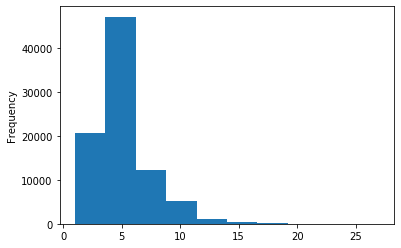

In [164]:
train_df['sentences_len'].plot.hist()
plt.show()

In [165]:
def generate_target(sentences,start_char_idx):
    target = 1
    tar = 0 
    for i in sentences:
        tar = tar + len(i)
        if(tar<start_char_idx):
          target +=1
    return target

In [166]:
train_df["target"]=train_df.apply(lambda row: generate_target(row[8],row[3]),axis=1)

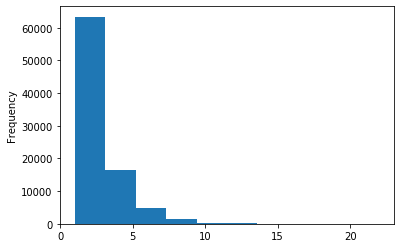

In [167]:
train_df['target'].plot.hist()
plt.show()

In [168]:
train_df.head()

question  \
0           When did Beyonce start becoming popular?   
1  What areas did Beyonce compete in when she was...   
2  When did Beyonce leave Destiny's Child and bec...   
3      In what city and state did Beyonce  grow up?    
4         In which decade did Beyonce become famous?   

                                           paragraph          answer_span  \
0  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...    in the late 1990s   
1  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...  singing and dancing   
2  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...                 2003   
3  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...       Houston, Texas   
4  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...           late 1990s   

   start  end  q_len  p_len  answer_span_len  \
0    269  286      6    109                4   
1    207  226     11    109                3   
2    526  530     11    109                1   
3    166  180      9    109                2   
4    276  286      7    109                2   

                                           sentences  sentences_len  target  
0  [Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ ...              4       2  
1  [Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ ...              4       2  
2  [Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ ...              4       4  
3  [Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ ...              4       2  
4  [Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ ...              4       2

In [169]:
def cosine_similarity(question,sentence_list):
    question = Sentence(question)
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    document_embeddings.embed(question)
    q_emd = question.get_embedding()
    q_emd = q_emd.unsqueeze(0)
    sentence_vectors =torch.empty((1,EMBEDDING_DIM)).to(device)
    for idx,sent in enumerate(sentence_list):
    
      sent = Sentence(sent)
      document_embeddings.embed(sent)
      sent_emd = sent.get_embedding()
      if  idx ==0:
            sentence_vectors =sent_emd.unsqueeze(0)
      else:
          sentence_vectors = torch.cat((sentence_vectors,sent_emd.unsqueeze(0)))

    output = cos(q_emd, sentence_vectors)

    _,max_index = torch.max(output,-1)
    return max_index.item()

In [170]:
# sentences = ['N-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress.',
#  "Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child.",
#  "Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time.",
#  'Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".']

# ques = "When did Beyonce start becoming popular?"
# max_sim_idx = cosine_similarity(ques,sentences)
# max_sim_idx

In [171]:
train_df["cosine_sim"]=train_df.apply(lambda row: cosine_similarity(row[0],row[8]),axis=1)

In [172]:
train_df["overlap_cosine"]=train_df.apply(lambda row: 1 if row[10]==row[11] else 0,axis=1)

In [176]:
# train_df["overlap_cosine"].plot.bar()

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x000002987A29F7B8> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000002987A2AF1E0> (for post_execute):


KeyboardInterrupt: 

In [178]:
train_df.to_csv("cosine_train.csv")